# Распознавание видов растений при помощи нейросети InceptionV3.

## 1. Описание и анализ датасета
Датасет состоит из 30000 изображений, на которых изображены 30 классов различных фруктов и овощей. Предположим, что мы не знаем сколько изображений находится в каждой папке, и проверим равномерность распределения файлов по папкам val, train и test при помощи matplotlib.

__1.1 Импорт библиотек, os для удобного указания пути и matplotlib для графиков__

In [25]:
import os
import matplotlib.pyplot as plt

__1.2 Указание пути к датасету и конкретно к папкам "train" и "val"__

In [26]:
data_dir = 'dataset'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

__1.3 Функция, подсчитывающая кол-во изображений в каждом классе выбранной директории.__

In [27]:
def count_images_in_directory(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

Функция проходится по каждой папке внутри выбранной директории и добавляет в словарь `class_counts` пару "название_папки: кол-во файлов в ней". Как только папки заканчиваются, функция возвращает заполненный словарь.

__1.4. Подсчет и вывод в консоль данных о каждой папке__

In [28]:
train_counts = count_images_in_directory(train_dir)
val_counts = count_images_in_directory(val_dir)
test_counts = count_images_in_directory(test_dir)
print(train_counts)
print(val_counts)
print(test_counts)

{'aloevera': 700, 'banana': 700, 'bilimbi': 700, 'cantaloupe': 700, 'cassava': 700, 'coconut': 700, 'corn': 700, 'cucumber': 700, 'curcuma': 700, 'eggplant': 700, 'galangal': 700, 'ginger': 700, 'guava': 700, 'kale': 700, 'longbeans': 700, 'mango': 700, 'melon': 700, 'orange': 700, 'paddy': 700, 'papaya': 700, 'peperchili': 700, 'pineapple': 700, 'pomelo': 700, 'shallot': 700, 'soybeans': 700, 'spinach': 700, 'sweetpotatoes': 700, 'tobacco': 700, 'waterapple': 700, 'watermelon': 700}
{'aloevera': 200, 'banana': 200, 'bilimbi': 200, 'cantaloupe': 200, 'cassava': 200, 'coconut': 200, 'corn': 200, 'cucumber': 200, 'curcuma': 200, 'eggplant': 200, 'galangal': 200, 'ginger': 200, 'guava': 200, 'kale': 200, 'longbeans': 200, 'mango': 200, 'melon': 200, 'orange': 200, 'paddy': 200, 'papaya': 200, 'peperchili': 200, 'pineapple': 200, 'pomelo': 200, 'shallot': 200, 'soybeans': 200, 'spinach': 200, 'sweetpotatoes': 200, 'tobacco': 200, 'waterapple': 200, 'watermelon': 200}
{'aloevera': 100, 'ban

Видим, что каждый класс в _train_ содержит ровно по 700=, в _val_ по 200, а в _test_ по 100 изображений. Осталось отобразить это графически

__1.5 Подготовка данных для построения графика__

In [29]:
classes = sorted(set(train_counts.keys()) | set(val_counts.keys()) | set(test_counts.keys()))
train_counts_list = [train_counts.get(cls, 0) for cls in classes]
val_counts_list = [val_counts.get(cls, 0) for cls in classes]
test_counts_list = [test_counts.get(cls, 0) for cls in classes]

__1.6 Построение графиков__

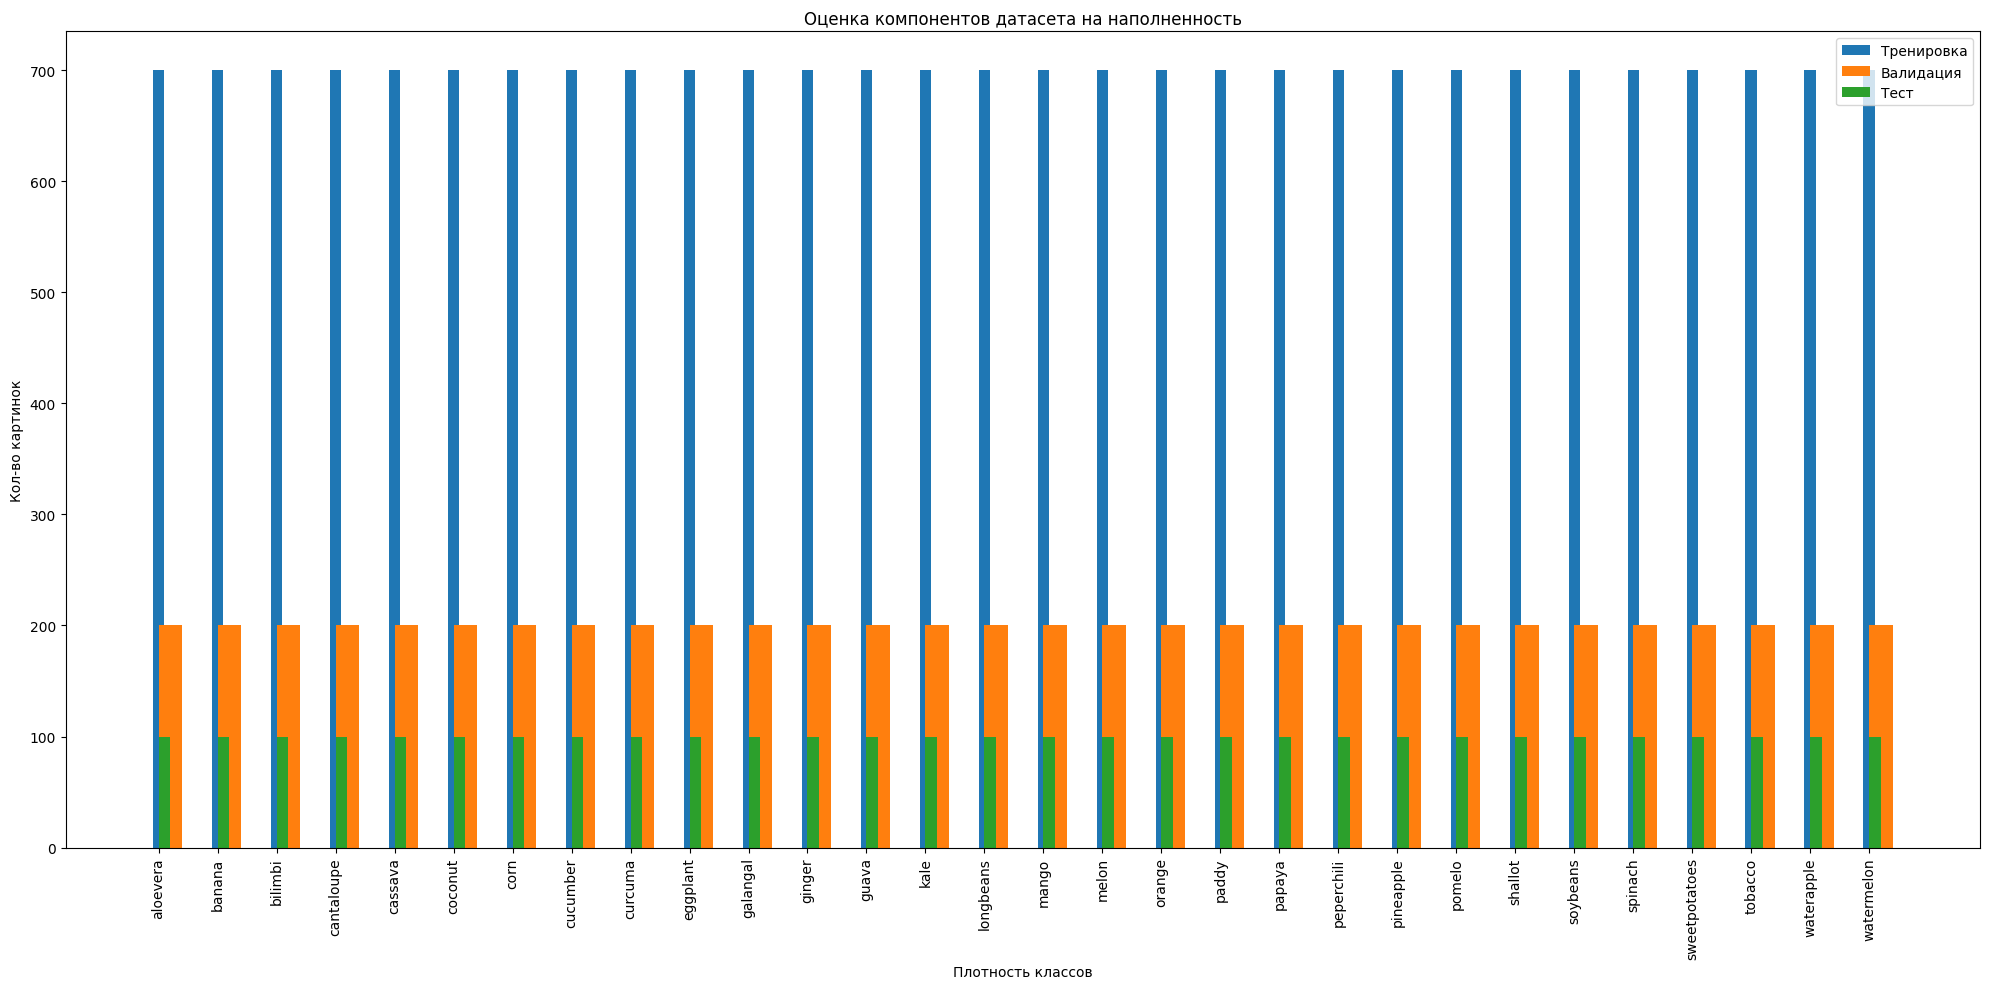

In [30]:
x = range(len(classes))
plt.figure(figsize=(20, 10))
plt.bar(x, train_counts_list, width=0.2, label='Тренировка', align='center')
plt.bar(x, val_counts_list, width=0.4, label='Валидация', align='edge')
plt.bar(x, test_counts_list, width=0.2, label='Тест', align='edge')

plt.xlabel('Плотность классов')
plt.ylabel('Кол-во картинок')
plt.title('Оценка компонентов датасета на наполненность')
plt.xticks(ticks=x, labels=classes, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Настройка среды и обучение нейросети
В основу моей нейросети будет взята предобученная модель, разработанная гуглом GoogLeNet. Она хорошо зарекомендовала себя на ImageNet, показав отличные результаты при распознавании изображений. Подробнее про архитектуру можно будет прочитать в отчёте.

__2.1 Импорт необходимых библиотек__

Сюда входят `numpy`, тысяча модулей из `tensorflow'а`, `datetime`(нужен для нейминга логов)

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
import tensorflow
import datetime

__2.2. Проверка работы GPU и совместимость с CUDA__

In [2]:
print("Доступно GPU: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

Доступно GPU:  1


In [3]:
if tensorflow.test.is_built_with_cuda():
    print("CUDA доступен и будет использован при обучении модели.")
else:
    print('CUDA недоступна, останавливаем программу...')
    sys.exit(1)

CUDA доступен и будет использован при обучении модели.


__2.3 Резервирование видеопамяти для обучения__
Если не позаботиться об динамическом выделении памяти под обучение нейросети, то может возникнуть ошибка и программа закончит свою работу. Предусмотрим такой расклад.


In [4]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tensorflow.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

__2.4. Указание директорий необходимых папок__
Сюда входят не только пути к датасетам, но и пути к папке models, куда будут сохраняться лучшие модели.

In [5]:
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, 'dataset')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
model_dir = os.path.join(base_dir, 'models')
logs_dir = os.path.join(base_dir, 'logs')
os.makedirs(model_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)

__2.5 Указание параметров обучения__
Выделил два параметра для регулировки обучения — это `batch_size` и `img_size`.
В процессе обучения использовал несколько пар этих значений, а именно:
1. `batch_size=32`, `img_size=150`
2. `batch_size=32`, `img_size=299`
3. `batch_size=64`, `img_size=150`
4. `batch_size=64`, `img_size=299`

Интуитивно понятно, что при большем размере изображения точность возрастет, так оно и оказалось на практике (графики тенсорборда будут представлены в отчёте). Получились примерно следующие результаты:

| batch_size | img_size | val_accuracy (25 эпох) | val_accuracy (Fine-Tuning, 20 эпох) |
|------------|----------|-----------------------|-------------------------------------|
| 32         | 150      | 0.68                  | 0.85                                |
| 32         | 299      | 0.85                  | 0.95                                |
| 64         | 150      | 0.74                  | 0.88                                |
| 64         | 299      | 0.76                  | комп не вывез                       |

Поэтому в приоритет взял размер изображения

In [14]:
batch_size = 32
img_size = 299
model_name = 'model_bs'+str(batch_size)+'_img'+str(img_size)

__2.6 Создание ImageDataGenerator'ов для тренировки и валидации__
Добавил большое количество аугментаций. Это силь

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2])

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 21000 images belonging to 30 classes.
Found 6000 images belonging to 30 classes.


__2.7 Загрузка InceptionV3, добавление слоёв и компиляция модели__

In [16]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

Заморозим слои InceptionV3:

In [17]:
for layer in base_model.layers:
    layer.trainable = False

А теперь добавим верхние слои:

In [18]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)             # Добавление BatchNormalization
x = Dropout(0.5)(x)                     # Добавление Dropout
predictions = Dense(30, activation='softmax')(x)

По сути верхние слои InceptionV3 такие же, как у меня в коде. Смысл в импорте именно _notop_ модели заключается в настройке выходного слоя. Ну и ещё я использую `BatchNormalization`, чтобы повысить производительность. Теперь дособерём модель и ради интереса выведем в консоль количество слоёв.

In [19]:
model = Model(inputs=base_model.input, outputs=predictions)
num_layers = len(model.layers)
print(f"Количество слоев в модели: {num_layers}")

Количество слоев в модели: 316


Скомпилируем модель с оптимизацией adam и большим `learning-rate'`ом

In [20]:
model.compile(optimizer=Adam(learning_rate=0.001),  loss='categorical_crossentropy', metrics=['accuracy'])

__2.8 Создание директории логов для TensorBoard__

In [21]:
log_dir = os.path.join(logs_dir, model_name)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

__2.9 Сохранение лучшей модели__

In [22]:
checkpoint = ModelCheckpoint(
    os.path.join(model_dir, model_name+'.h5'),
    save_best_only=True,
    monitor='val_loss',
    mode='min')

__2.10 Первичное обучение модели__

In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch=np.ceil(21000 / batch_size),
    epochs=25,
    validation_data=validation_generator,
    validation_steps=np.ceil(6000 / batch_size),
    callbacks=[checkpoint, tensorboard_callback])

Epoch 1/25
657/657 [==============================] - 458s 680ms/step - loss: 1.4984 - accuracy: 0.5880 - val_loss: 0.7808 - val_accuracy: 0.7585
Epoch 2/25
657/657 [==============================] - 438s 666ms/step - loss: 1.1372 - accuracy: 0.6620 - val_loss: 0.7568 - val_accuracy: 0.7638
Epoch 3/25
657/657 [==============================] - 449s 683ms/step - loss: 1.0522 - accuracy: 0.6820 - val_loss: 0.7075 - val_accuracy: 0.7735
Epoch 4/25
657/657 [==============================] - 447s 679ms/step - loss: 1.0032 - accuracy: 0.6980 - val_loss: 0.6829 - val_accuracy: 0.7857
Epoch 5/25
657/657 [==============================] - 442s 672ms/step - loss: 0.9767 - accuracy: 0.7015 - val_loss: 0.7059 - val_accuracy: 0.7765
Epoch 6/25
657/657 [==============================] - 443s 674ms/step - loss: 0.9750 - accuracy: 0.7020 - val_loss: 0.7212 - val_accuracy: 0.7705
Epoch 7/25
657/657 [==============================] - 454s 690ms/step - loss: 0.9476 - accuracy: 0.7097 - val_loss: 0.6669 -

__2.11 Разморозка слоёв и дообучение модели (Fine-Tuning)__

In [24]:
for layer in base_model.layers:
    layer.trainable = True

Повторная компиляция модели с размороженными слоями и пониженным learning-rate`
Так же создал отдельную директорию логов под "дообучение", чтобы график тенсорборда не ломался из-за сброса нумерации эпох до нуля

In [25]:
log_dir = os.path.join(logs_dir, model_name+'дообучение')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

Дообучение модели. `epochs` уменьшены до 15

In [27]:
history = model.fit(
    train_generator,
    steps_per_epoch=np.ceil(21000 / batch_size),
    epochs=15,
    validation_data=validation_generator,
    validation_steps=np.ceil(6000 / batch_size),
    callbacks=[checkpoint, tensorboard_callback])

Epoch 1/15
657/657 [==============================] - 495s 732ms/step - loss: 1.0170 - accuracy: 0.6952 - val_loss: 0.5258 - val_accuracy: 0.8303
Epoch 2/15
657/657 [==============================] - 487s 741ms/step - loss: 0.7546 - accuracy: 0.7629 - val_loss: 0.4505 - val_accuracy: 0.8550
Epoch 3/15
657/657 [==============================] - 500s 761ms/step - loss: 0.6411 - accuracy: 0.7907 - val_loss: 0.4060 - val_accuracy: 0.8648
Epoch 4/15
657/657 [==============================] - 512s 778ms/step - loss: 0.5714 - accuracy: 0.8121 - val_loss: 0.3734 - val_accuracy: 0.8765
Epoch 5/15
657/657 [==============================] - 499s 759ms/step - loss: 0.5089 - accuracy: 0.8276 - val_loss: 0.3708 - val_accuracy: 0.8748
Epoch 6/15
657/657 [==============================] - 497s 756ms/step - loss: 0.4583 - accuracy: 0.8440 - val_loss: 0.3462 - val_accuracy: 0.8860
Epoch 7/15
657/657 [==============================] - 489s 743ms/step - loss: 0.4167 - accuracy: 0.8584 - val_loss: 0.3379 -